<a href="https://colab.research.google.com/github/AryaR-06/linear-regression/blob/main/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# linear regression

## introduction

1. the goal of this project is to code basic linear regression from "scratch," while explaining the theory of regression in a way students with minimal background can understand

    -   this code assumes the reader has an intermediate understanding of calculus, linear algebra, and Python programming

    -   while libraries like sklearn allow users to easily perform linear regression,
        this tutorial breaks down the inner workings of the algorithm, focusing on matrix operations and gradient descent

    -   this implementation is not optimized for production use; it is intended purely for educational purposes

2. this code imports pandas and numpy, which assist with data manipulation and matrix computations

    -   pandas simplifies data cleaning and preprocessing tasks

    -   numpy provides efficient matrix operations essential for implementing linear regression

    -   while these libraries are not strictly necessary, their inclusion avoids redundant coding of fundamental operations

    -   sklearn is included to benchmark the custom implementation against an industry-standard library

3. basic theory:

    -   linear regression models the relationship between a dependent variable, y, and one or more independent variables

    -   the model predicts y based on a linear combination of the independent variables and their respective coefficients

    -   each coefficient represents the effect of its corresponding independent variable on y

    -   the model also includes an intercept term, which accounts for the value of y when all independent variables are zero

    -   in total, there are m + 1 parameters (m coefficients and 1 intercept)

    -   the goal of linear regression is to find the parameters that minimize the prediction error and make accurate predictions on new data

4. data

    -   this project uses a dataset aimed at predicting food delivery times based on various factors

    -   source: https://www.kaggle.com/datasets/denkuznetz/food-delivery-time-prediction/data

    -   while this code is tailored to the provided dataset, it can be adapted to other datasets
        as long as a linear relationship exists between the variables

    -   linear regression is often a first step to evaluate the relationships between variables before exploring more complex models

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## preprocess (data)

1.  this function is tailored to the provided dataset

2.  its primary objectives are:

    -   identify and separate the dependent (target) and independent (predictor) variables

    -   remove unnecessary or irrelevant data columns

    -   convert non-numeric data into numerical format (e.g., integers or floats)
        to enable mathematical operations

    -   structure the data into matrices for computation

3.  this function returns X, B, and Y:

    -   let m be the number of independent variables and n be the number of observations

    -   Y is a matrix containing the dependent variable, with dimensions (n, 1)

    -   B is a matrix of coefficients for the independent variables, with dimensions (m + 1, 1)

    -   X is a matrix of independent variables, with dimensions (n, m + 1)

4.  column 1 of X:

    -   the first column of X consists of ones, corresponding to the y-intercept term in B

    -   this column ensures the inclusion of an intercept in the linear model

    -   since there are m + 1 coefficients in total, we include this column explicitly

5.  initializing B:

    -   the goal is to optimize B (find the ideal coefficients)

    -   initially, all elements of B are set to one as a naive starting guess

    -   this function only prepares the matrices; optimization is performed in subsequent steps

6.  splitting data into training and validation sets:

    -   the data is divided into training and validation subsets to assess the model's performance

    -   the training set is used to compute B, while the validation set tests whether B generalizes well

    -   overfitting occurs when the model performs well on training data but poorly on unseen data

    -   to mitigate overfitting, the validation set ensures the model's predictions are reliable

    -   an 80-20 train-validation split is used, though other splits may yield different results

In [ ]:
def preprocess (data):
    Y = data[["Delivery_Time_min"]] # Dependent variable
    X = data.drop(columns=["Order_ID", "Delivery_Time_min"])  # Independent variables

    # Convert string data to numerical values
    X = pd.get_dummies(X, columns=["Weather", "Time_of_Day", "Vehicle_Type"])
    X["Traffic_Level"] = X["Traffic_Level"].astype("category").cat.codes

    # Convert bool to float
    X = X.astype(float)
    Y = Y.astype(float)

    # Remove rows with NaN in them
    combined = pd.concat([X, Y], axis=1)
    combined = combined.dropna()
    X = combined.iloc[:, :-1]
    Y = combined.iloc[:, -1]

    # convert from pandas to numpy
    X = X.to_numpy()
    Y = Y.to_numpy().reshape(-1, 1)

    B = np.ones((X.shape[1] + 1, 1))  # create coefficients matrix

    X = np.hstack ((np.ones((X.shape[0], 1)), X)) # Add y-intercept column to X

    # Split point (80% for training, 20% for validation)
    split_point = round(Y.shape[0]*0.8)
    X = {"training": X[:split_point, :], "validation": X[split_point:, :]}
    Y = {"training": Y[:split_point], "validation": Y[split_point:]}

    return X, B, Y

## gradient_descent (X, B, Y, learning_rate)

1.  as promised, we will now solve for the optimal B matrix

2.  how do we find the best coefficients?

    -   the error vector error of the fit is given by: `E = Y - X*B`

    -   in words, this is a vector that tells us how much the predicted value deviates from the actual y value of a point

    -   the predicted value comes from multiplying our dependent variables with the current version of B, the coefficients

    -   `X*B`, is a concise way of making this prediction

    -   we turn this vector into a scalar: `e = (1/n)*(Y - X*B)**2`

    -   this is the error squared of the fit, on average

    -   the best fit occurs when the magnitude of the error vector is minimized,
        which is equivalant to minimizing the scalar 'e'

2. to minimize the 'e', we must use optimization

    -   as seen in the formula, 'e' changes with any change to the components of B

    -   'e' is therefore a function of B, `e(B)`

    -   to optimize 'e' we take its derivative with respect to B

    -   it is found by computing the partial derivative with respect to every element of B

    -   combining all the rates of change into a vector gives us the total rate of change, or the gradient of e

3.  computing the gradient

    -   intuitively, the partial derivative finds the rate of change of e when just one value in B is changed

    -   mathematically, it is found by treating every variable except the target as a constant

    -   the partial derivative with respect to the m-th element in B is: `(-2/n)*dot(X_m, (Y - X*B))`,
        where X_m is the m-th column in X

    -   this result can be found by writing `e(B)` as sum rather than vector form, this is left as an exercise

    -   the gradient vector is found by combining the m+1 partial derivatives into a vector with shape (m+1, 1)

    -   with some manipulation, we find it is equal to: `(-2/n)*X.T*(Y - X*B)`, where X.T is the transpose of X

    -   we are multiplying a (m + 1, n) matrix by a (n, 1) vector, leading to a (m + 1, 1) vector as expected

4.  using the gradient

    -   setting the gradient to zero is one way to find the critical points of e

    -   however, this is usually considered inefficient

    -   rather, we will resort to numerical methods, which are more efficient for a computer to perform

    -   a property of the gradient is that it always points in the direction of steepest increase

    -   this is makes sense intuitively because a steep increase in a certain direction means a larger partial derivative for that component, and the partial derivatives make up the gradient

    -   if one component of the gradient is much larger than the others, the function will largely go in that direction

    -   it follows that the gradient does point in the direction of steepest increase (intuitively, not rigorously)

    -   the following the steepest increase leads to the maximum (think of climbing a mountain)

    -   it is not a stretch to state that the opposite of the direction of steepest increase leads to the minimum

5.  finding the ideal B vector

    -   how do we use all this theory to find B?

    -   we know that increasing B in the direction of the gradient, i.e. adding the gradient to B,  
        will lead to the error growing

    -   it follows that subtracting the same gradient will lead to a decrease in error

    -   we now have a basic update equation for optimizing B: `B_new = B_old - DELTA_B`, where DELTA_B denotes the gradient evaluated at B

    -   in this equation, if DELTA_B is too large, we might overshoot the optimal value of B

    -   to account for this, we scale DELTA_B: `B_new = B_old - learning_rate*DELTA_B`, where learning rate is a small positive float

In [ ]:
def gradient_descent (X, B, Y, learning_rate):
    DELTA_B = (-2/Y.shape[0])*(X.T@(Y - X@B)) # @ is numpy syntax for matrix multiplication

    B_new = B - learning_rate*DELTA_B

    return B_new

## r_squared (X, B, Y)

1.  this function computes the R-squared value

  - this value is required to compute the stopping condition when iterating through possible B values

  - the need for this function is explained in the main block

In [ ]:
def r_squared (X, B, Y):
    e = (1/Y.shape[0])*(np.linalg.norm((Y - X@B)))**2
    R2 = 1 - e/np.var(Y)
    return R2

## main

1.  methods of iteration

    -   gradient descent involves incrementally adjusting B to reduce prediction error

    -   these adjustments must be repeated multiple times to meaningfully improve B

    -   this requires a loop, with two common approaches:

        -   fixed iterations: predefine the number of iterations (e.g., using a for loop)

        -   dynamic: continue updating B until the error falls below a defined threshold (e.g., using a while loop)

    -   this code uses the dynamic approach for flexibility in achieving the desired error threshold

2.  error

    -   defining an acceptable error threshold is critical for determining convergence

    -   R-squared is used as the metric for this purpose, scaled from 0 to 1 (1 indicates a perfect fit)

    -   an R-squared value of `0.73` is used as the threshold, chosen based on dataset characteristics and practical runtime considerations

    -   this value was selected after observing the graph of R-squared vs. iterations, which shows diminishing improvements beyond this point

    -   R-squared is calculated as: `R**2 = 1 - e/var(Y)`, where `var(Y)` is the variance of Y

    -   minimizing the error term, 'e', effectively maximizes R-squared

3.  learning rate

    -   the learning rate controls the step size for each gradient descent update

    -   a high learning rate risks overshooting the optimal B value, leading to oscillation or divergence

    -   a low learning rate may result in slow convergence, requiring excessive iterations

    -   based on test runs, a learning rate of `1e-3` was found to balance speed and stability effectively

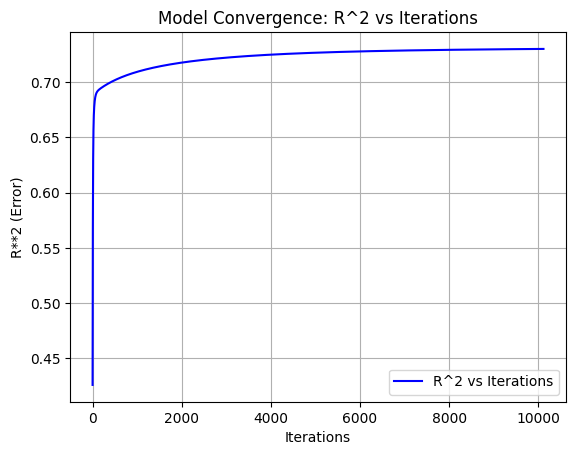

---
It took 10115 iterations at a learning rate of 0.001 to acheive an error of 0.730000078164206
The fit equation results in an R**2 error of 0.7654692673410143 on the validation set
Sklearn's regression results in an R**2 error of 0.761092523761633 on the validation set
---
Sample predictions using optimal B vector:
---
Predicted delivery time: 41 minutes
Actual delivery time: 43 minutes
---
Predicted delivery time: 36 minutes
Actual delivery time: 40 minutes
---
Predicted delivery time: 82 minutes
Actual delivery time: 89 minutes
---
Predicted delivery time: 76 minutes
Actual delivery time: 60 minutes
---
Predicted delivery time: 54 minutes
Actual delivery time: 51 minutes
---


In [ ]:
if __name__ == "__main__":
    file = "/content/drive/MyDrive/linear_regression/Food_Delivery_Times.csv"  # Ensure that drive is mounted if running on colab
    data = pd.read_csv(file)   # Load data as a pandas file
    X, B, Y = preprocess (data)     # Convert data to matrix form

    # Define hyperparameters
    learning_rate = 1e-3
    error_threshold = 0.8

    counter = 0

    # Required for plotting purposes
    error = []
    iteration = []

    # Initialize error
    R2 = r_squared (X["training"], B, Y["training"])

    while R2 <= 0.73:
        if counter >= 1e6:  # Prevent infinite loop
            print ("Fit not converging, try different parameters")
            break

        B = gradient_descent (X["training"], B, Y["training"], learning_rate)
        R2 = r_squared (X["training"], B, Y["training"])
        counter += 1

        iteration.append(counter)
        error.append(R2)

    # Generate plot
    plt.plot(iteration, error, label="R^2 vs Iterations", color="blue")
    plt.title("Model Convergence: R^2 vs Iterations")
    plt.xlabel("Iterations")
    plt.ylabel("R**2 (Error)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Use sklearn
    model = LinearRegression()
    model.fit(X["training"], Y["training"])
    Y_pred = model.predict(X["validation"])
    r2_sklearn = r2_score(Y["validation"], Y_pred)


    print (f"---\nIt took {counter} iterations at a learning rate of {learning_rate} to acheive an error of {R2}")
    print(f"The fit equation results in an R**2 error of {r_squared(X['validation'], B, Y['validation'])} on the validation set")
    print(f"Sklearn's regression results in an R**2 error of {r2_sklearn} on the validation set")
    print ("---")
    print(f"Sample predictions using optimal B vector:")
    print ("---")

    for i in range(5):
        y_pred = X["validation"][i, :]@B
        y_actual = Y["validation"][i, :]

        print (f"Predicted delivery time: {round(y_pred[0])} minutes")
        print (f"Actual delivery time: {round(y_actual[0])} minutes")
        print ("---")

## conclusion

1.  limitations of predictions

    -   the predictions are not perfect, which can be attributed to several factors:

        -   limited or insufficient data

        -   suboptimal hyperparameter choices (e.g., learning rate)

        -   non-linear relationships in the data that linear regression cannot capture

        -   limitations in the error metric (R-squared) or gradient descent implementation

    -   while predictions will never be flawless, addressing these issues—such as
        optimizing hyperparameters or exploring more complex models—can enhance accuracy

2.  concluding remarks

    -   this project provides a foundational understanding of linear regression by implementing it from scratch

    -   any feedback or suggestions for improvement are welcome to refine and expand the scope of this guide

    -   this implementation is a stepping stone toward exploring more advanced machine learning concepts and techniques